In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                #transforms.RandomRotation((-10.0, 10.0)),
                                transforms.RandomHorizontalFlip()
                                ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane  deer  ship  ship  bird


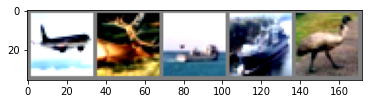

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# # functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# # get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:5]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(16),
                      nn.ReLU(),
                      nn.Dropout(0.15))

        self.conv2 = nn.Sequential(nn.Conv2d(16, 16, 3, groups=1, dilation=2, padding=2, bias=False),
                      nn.BatchNorm2d(16),
                      nn.ReLU())

        # Transition 1
        self.pool1 = nn.MaxPool2d(2, 2) 

        self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(32),
                      nn.ReLU(),
                      nn.Dropout(0.15))
        self.conv4 = nn.Sequential(nn.Conv2d(32, 32, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(32),
                      nn.ReLU(),
                      nn.Dropout(0.15))

        # Transition 2
        self.pool2 = nn.MaxPool2d(2, 2) 

        self.conv5 = nn.Sequential(nn.Conv2d(32, 64, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.Dropout(0.15))
        self.conv6 = nn.Sequential(nn.Conv2d(64, 64, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(64),
                      nn.ReLU())

        # Transition 3
        self.pool3 = nn.MaxPool2d(2, 2) 
        self.conv7 = nn.Sequential(nn.Conv2d(64, 64, 3, groups=64, dilation=1, padding=1, bias=False),
                                    nn.Conv2d(64, 128, 1, groups=1, dilation=1, bias=False),                                 
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.conv8 = nn.Sequential(nn.Conv2d(128, 128, 3, groups=128, dilation=1, padding=1, bias=False),
                                    nn.Conv2d(128, 128, 1, groups=1, dilation=1, bias=False),                                 
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        # GAP
        self.gap = nn.AvgPool2d(kernel_size=(4,4))
        self.conv9 = nn.Sequential(nn.Conv2d(128, 10, 1, padding=0, bias=False)) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = self.pool3(x)
        x = self.conv7(x)
        x = self.conv8(x)

        x = self.gap(x)
        x = self.conv9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


net = Net()

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           4,608
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
      BatchNorm2d-14           [-1

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5, weight_decay=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, nesterov = True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(trainloader), epochs=EPOCHS)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [8]:
from tqdm import tqdm

def train(model, device, train_loader, criterion, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  lambda_l1 = 0.005
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    # l1 = 0
    # for p in model.parameters():
    #   l1 = l1 + p.abs().sum()
    # loss = loss + lambda_l1 * l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar_str = f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    pbar.set_description(desc= pbar_str)


def test(model, device, test_loader, criterion, classes, test_losses, test_accs, misclassified_imgs, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))
    
    return test_loss, test_accs, misclassified_imgs

In [9]:
test_losses = []
test_accs = []
misclassified_imgs = []
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model, device, trainloader, criterion, optimizer, epoch)
  test_loss, test_accs, misclassified_imgs = test(model, device, testloader, criterion, classes, test_losses, test_accs, misclassified_imgs, epoch)
  scheduler.step(test_loss)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.0770715475082397 Batch_id=390 Accuracy=46.11: 100%|██████████| 391/391 [00:23<00:00, 16.89it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0097, Accuracy: 5589/10000 (55.89%)

EPOCH: 1


Loss=0.9303143620491028 Batch_id=390 Accuracy=63.63: 100%|██████████| 391/391 [00:23<00:00, 16.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 6754/10000 (67.54%)

EPOCH: 2


Loss=0.9676092863082886 Batch_id=390 Accuracy=69.29: 100%|██████████| 391/391 [00:22<00:00, 17.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 6425/10000 (64.25%)

EPOCH: 3


Loss=0.7213338613510132 Batch_id=390 Accuracy=72.32: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0068, Accuracy: 7010/10000 (70.10%)

EPOCH: 4


Loss=0.6669091582298279 Batch_id=390 Accuracy=73.96: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 7024/10000 (70.24%)

EPOCH: 5


Loss=0.4709600508213043 Batch_id=390 Accuracy=75.45: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 7384/10000 (73.84%)

EPOCH: 6


Loss=0.8092519640922546 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:22<00:00, 17.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 7545/10000 (75.45%)

EPOCH: 7


Loss=0.5120481252670288 Batch_id=390 Accuracy=76.49: 100%|██████████| 391/391 [00:23<00:00, 16.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0062, Accuracy: 7280/10000 (72.80%)

EPOCH: 8


Loss=0.8878387212753296 Batch_id=390 Accuracy=76.97: 100%|██████████| 391/391 [00:22<00:00, 17.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0061, Accuracy: 7285/10000 (72.85%)

EPOCH: 9


Loss=0.6345533132553101 Batch_id=390 Accuracy=77.18: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 7473/10000 (74.73%)

EPOCH: 10


Loss=0.6372666358947754 Batch_id=390 Accuracy=77.47: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 6937/10000 (69.37%)

EPOCH: 11


Loss=0.717268168926239 Batch_id=390 Accuracy=77.82: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 7452/10000 (74.52%)

EPOCH: 12


Loss=0.6723755598068237 Batch_id=390 Accuracy=78.02: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7629/10000 (76.29%)

EPOCH: 13


Loss=0.6191349625587463 Batch_id=390 Accuracy=78.47: 100%|██████████| 391/391 [00:23<00:00, 16.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0063, Accuracy: 7341/10000 (73.41%)

EPOCH: 14


Loss=0.6398614645004272 Batch_id=390 Accuracy=78.61: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7615/10000 (76.15%)

EPOCH: 15


Loss=0.7683817744255066 Batch_id=390 Accuracy=78.66: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 7341/10000 (73.41%)

EPOCH: 16


Loss=0.5576223134994507 Batch_id=390 Accuracy=78.73: 100%|██████████| 391/391 [00:23<00:00, 16.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7594/10000 (75.94%)

EPOCH: 17


Loss=0.5929468274116516 Batch_id=390 Accuracy=79.20: 100%|██████████| 391/391 [00:23<00:00, 16.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0053, Accuracy: 7723/10000 (77.23%)

EPOCH: 18


Loss=0.6516371965408325 Batch_id=390 Accuracy=79.19: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 7556/10000 (75.56%)

EPOCH: 19


Loss=0.6687647104263306 Batch_id=390 Accuracy=78.96: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7562/10000 (75.62%)

EPOCH: 20


Loss=0.6925885081291199 Batch_id=390 Accuracy=79.34: 100%|██████████| 391/391 [00:23<00:00, 16.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0058, Accuracy: 7427/10000 (74.27%)

EPOCH: 21


Loss=0.8248409032821655 Batch_id=390 Accuracy=79.56: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7804/10000 (78.04%)

EPOCH: 22


Loss=0.6872161626815796 Batch_id=390 Accuracy=79.46: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7614/10000 (76.14%)

EPOCH: 23


Loss=0.6478419899940491 Batch_id=390 Accuracy=79.42: 100%|██████████| 391/391 [00:23<00:00, 16.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 7453/10000 (74.53%)

EPOCH: 24


Loss=0.6414827108383179 Batch_id=390 Accuracy=79.46: 100%|██████████| 391/391 [00:23<00:00, 16.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0058, Accuracy: 7517/10000 (75.17%)

EPOCH: 25


Loss=0.5865636467933655 Batch_id=390 Accuracy=79.64: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0053, Accuracy: 7633/10000 (76.33%)

EPOCH: 26


Loss=0.6530784368515015 Batch_id=390 Accuracy=79.76: 100%|██████████| 391/391 [00:23<00:00, 16.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7542/10000 (75.42%)

EPOCH: 27


Loss=0.4925598204135895 Batch_id=390 Accuracy=79.59: 100%|██████████| 391/391 [00:23<00:00, 16.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0064, Accuracy: 7299/10000 (72.99%)

EPOCH: 28


Loss=0.7708942890167236 Batch_id=390 Accuracy=80.12: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7572/10000 (75.72%)

EPOCH: 29


Loss=0.47368282079696655 Batch_id=390 Accuracy=80.15: 100%|██████████| 391/391 [00:23<00:00, 16.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7721/10000 (77.21%)

EPOCH: 30


Loss=0.5364192724227905 Batch_id=390 Accuracy=80.03: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7607/10000 (76.07%)

EPOCH: 31


Loss=0.5864955186843872 Batch_id=390 Accuracy=79.96: 100%|██████████| 391/391 [00:23<00:00, 16.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0058, Accuracy: 7487/10000 (74.87%)

EPOCH: 32


Loss=0.6403967142105103 Batch_id=390 Accuracy=79.98: 100%|██████████| 391/391 [00:23<00:00, 16.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 7317/10000 (73.17%)

EPOCH: 33


Loss=0.5570176243782043 Batch_id=390 Accuracy=80.11: 100%|██████████| 391/391 [00:23<00:00, 16.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 7384/10000 (73.84%)

EPOCH: 34


Loss=0.7594859004020691 Batch_id=390 Accuracy=80.09: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7749/10000 (77.49%)

EPOCH: 35


Loss=0.6547126770019531 Batch_id=390 Accuracy=80.13: 100%|██████████| 391/391 [00:23<00:00, 16.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7556/10000 (75.56%)

EPOCH: 36


Loss=0.5617671608924866 Batch_id=390 Accuracy=80.49: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7928/10000 (79.28%)

EPOCH: 37


Loss=0.6474022269248962 Batch_id=390 Accuracy=80.38: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7577/10000 (75.77%)

EPOCH: 38


Loss=0.7775545120239258 Batch_id=390 Accuracy=80.17: 100%|██████████| 391/391 [00:23<00:00, 16.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 7493/10000 (74.93%)

EPOCH: 39


Loss=0.7080946564674377 Batch_id=390 Accuracy=80.34: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 7785/10000 (77.85%)

EPOCH: 40


Loss=0.4607936441898346 Batch_id=390 Accuracy=80.07: 100%|██████████| 391/391 [00:23<00:00, 16.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0048, Accuracy: 7922/10000 (79.22%)

EPOCH: 41


Loss=0.5624516606330872 Batch_id=390 Accuracy=80.47: 100%|██████████| 391/391 [00:23<00:00, 16.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 7951/10000 (79.51%)

EPOCH: 42


Loss=0.6471911072731018 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 6809/10000 (68.09%)

EPOCH: 43


Loss=0.6903659701347351 Batch_id=390 Accuracy=80.62: 100%|██████████| 391/391 [00:23<00:00, 16.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0065, Accuracy: 7172/10000 (71.72%)

EPOCH: 44


Loss=0.4757664203643799 Batch_id=390 Accuracy=80.65: 100%|██████████| 391/391 [00:22<00:00, 17.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 7492/10000 (74.92%)

EPOCH: 45


Loss=0.44674721360206604 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7734/10000 (77.34%)

EPOCH: 46


Loss=0.4441325068473816 Batch_id=390 Accuracy=80.81: 100%|██████████| 391/391 [00:23<00:00, 16.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 7423/10000 (74.23%)

EPOCH: 47


Loss=0.4234324097633362 Batch_id=390 Accuracy=80.60: 100%|██████████| 391/391 [00:23<00:00, 16.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7514/10000 (75.14%)

EPOCH: 48


Loss=0.4385300576686859 Batch_id=390 Accuracy=80.57: 100%|██████████| 391/391 [00:23<00:00, 16.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 7878/10000 (78.78%)

EPOCH: 49


Loss=0.5149949789047241 Batch_id=390 Accuracy=80.67: 100%|██████████| 391/391 [00:23<00:00, 16.53it/s]


Test set: Average loss: 0.0048, Accuracy: 7889/10000 (78.89%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [10]:
def classwise(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

classwise(model, device, testloader, classes)

Accuracy of plane : 82 %
Accuracy of   car : 75 %
Accuracy of  bird : 75 %
Accuracy of   cat : 79 %
Accuracy of  deer : 77 %
Accuracy of   dog : 60 %
Accuracy of  frog : 83 %
Accuracy of horse : 84 %
Accuracy of  ship : 93 %
Accuracy of truck : 89 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


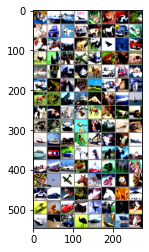

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    car   car  bird   car


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))